#Cats or Dogs - using CNN with transfer Learning (VGG16) 📷 🚀

The Dogs & Cats is a foundational problem for a basic CNN(convolutional neural network) model which involves classifying images as a dog or a cat.The dataset can be used for learning how to develop,evaluate and use convolutional deep learning neural networks for classification of images. This includes how to develop a robust test harness for estimating the performance of the model, exploring improvements for the model by changing the paramters of the model, saving and loading the model to make predicitions on new data.


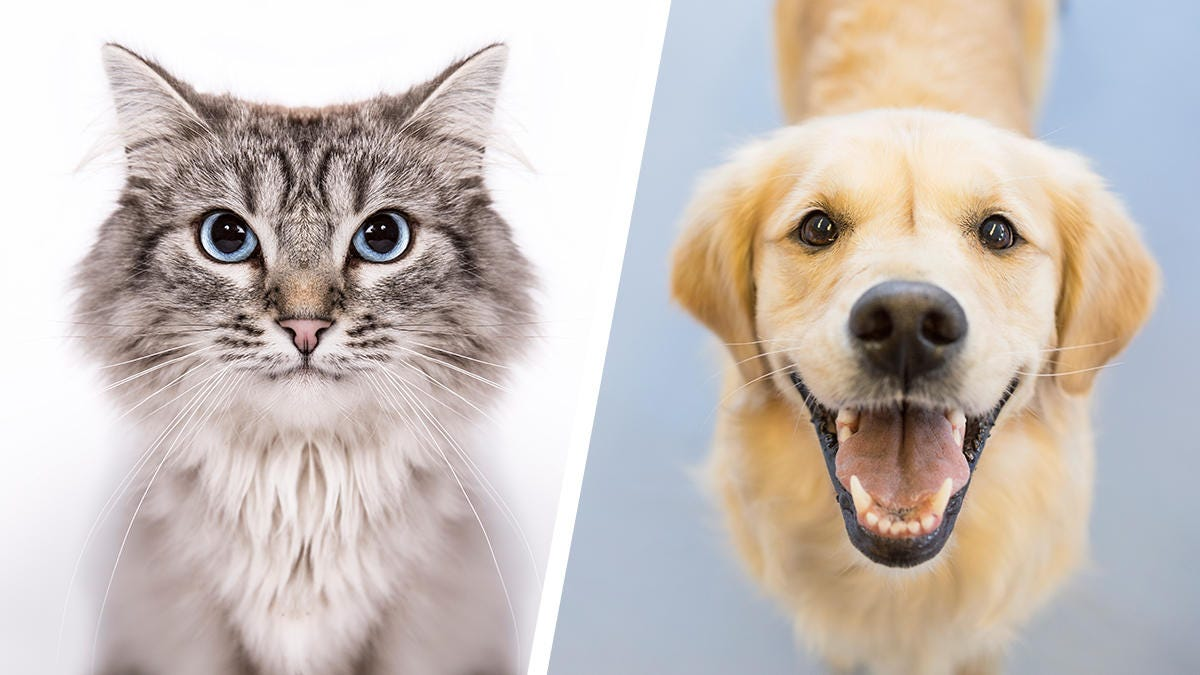

# Introduction 💥

In this project , we will discover how to develop a `CNN` to classify images of dogs and cats using a pre-trained model.

<b>Dataset:</b> The train folder contains 25,000 images of dogs and cats. each iamge in this folder has the label as part of the filename. the test folder contions 12,500 images, names acording to a numeric id. For each image in the test set, you should prdict a probability that the image is dog(1 = dog, 0= cat) or a cat.

<b>Method:</b> For the soution of this problem we will use a pre trained model, VGG16.

### Data link : https://www.kaggle.com/datasets/jessicali9530/stanford-dogs-dataset

# Loading Libraries

In [1]:
#Basic
import os
import zipfile
import numpy as np
import pandas as pd

# Visual
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2 as cv
from matplotlib.image import  imread

# Sklearn
from sklearn.metrics import  classification_report,confusion_matrix,ConfusionMatrixDisplay
from sklearn.model_selection import  train_test_split

# Tensorflow
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau,EarlyStopping
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.models import Sequential,Model
from keras.layers import Flatten,Dense,Dropout

import warnings
warnings.filterwarnings('ignore')

In [2]:
! mv kaggle.json /root/.kaggle/

In [3]:
import kaggle

In [4]:
! kaggle competitions download -c dogs-vs-cats

 97% 788M/812M [00:05<00:00, 202MB/s]
100% 812M/812M [00:05<00:00, 166MB/s]


In [5]:
!unzip -q dogs-vs-cats.zip

In [6]:
!unzip -q train.zip

In [7]:
!unzip -q test1.zip

In [8]:
filenames = os.listdir('/content/train')
labels = [x.split('.')[0] for x in filenames]

In [9]:
data = pd.DataFrame({'filename':filenames,'label':labels})
data.head()

,filename,label
0,dog.2785.jpg,dog
1,cat.2303.jpg,cat
2,cat.7099.jpg,cat
3,dog.12428.jpg,dog
4,dog.8047.jpg,dog


# Data Exploraton

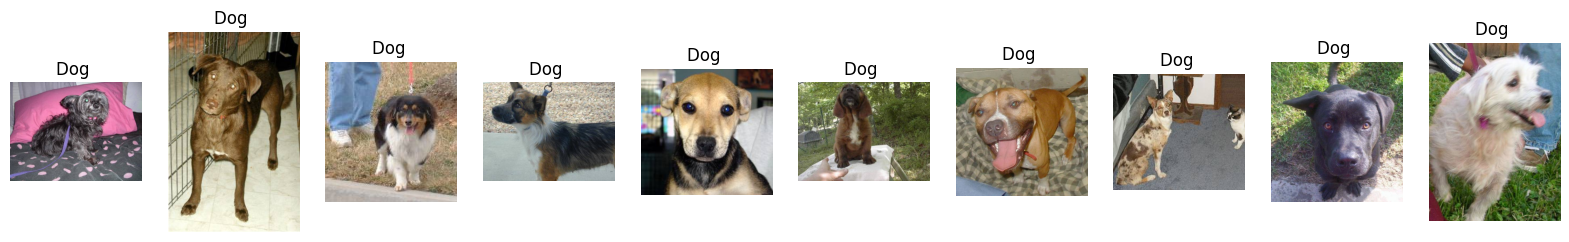

In [10]:
plt.figure(figsize=(20,20))

plt.subplots_adjust(hspace=0.4)

for  i in range(10):
  plt.subplot(1, 10, i+1)
  filename = 'train/' + 'dog.' + str(i) + '.jpg'
  image = imread(filename)
  plt.imshow(image)
  plt.title('Dog ',fontsize=12)
  plt.axis('off')

plt.show()

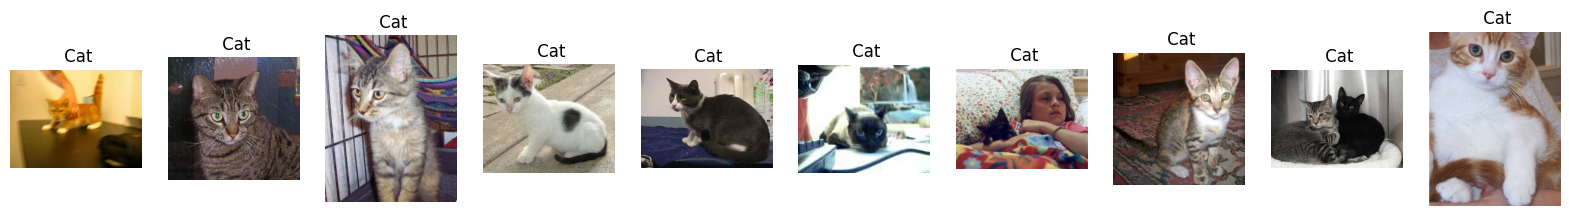

In [11]:
plt.figure(figsize=(20,20))

plt.subplots_adjust(hspace=0.4)

for  i in range(10):
  plt.subplot(1, 10, i+1)
  filename = 'train/' + 'cat.' + str(i) + '.jpg'
  image = imread(filename)
  plt.imshow(image)
  plt.title(' Cat',fontsize=12)
  plt.axis('off')

plt.show()

Images are of varying size.

Every time the cell is run different set of images will be displayed, one can scan the images of both categories. Presence of humans in some images could be a challenge for the model to classify.

Some images have more than one cats or dogs respectively.

# Data Preparation

### Train Test Split

In [12]:
labels = data['label']
X_train, X_temp = train_test_split(data, test_size=0.2, stratify=labels,random_state=23)

label_test_val = X_temp['label']
X_test, X_val = train_test_split(X_temp,test_size=0.5,stratify=label_test_val,random_state=23)

In [13]:
labels = ['Cat','Dog']

label1, count1 = np.unique(X_train.label,return_counts=True)
label2, count2 = np.unique(X_train.label,return_counts=True)
label3, count3 = np.unique(X_train.label,return_counts=True)

uni1 = pd.DataFrame(data=count1,index=labels,columns=['Count1'])
uni2 = pd.DataFrame(data=count2,index=labels,columns=['Count2'])
uni3 = pd.DataFrame(data=count3,index=labels,columns=['Count3'])



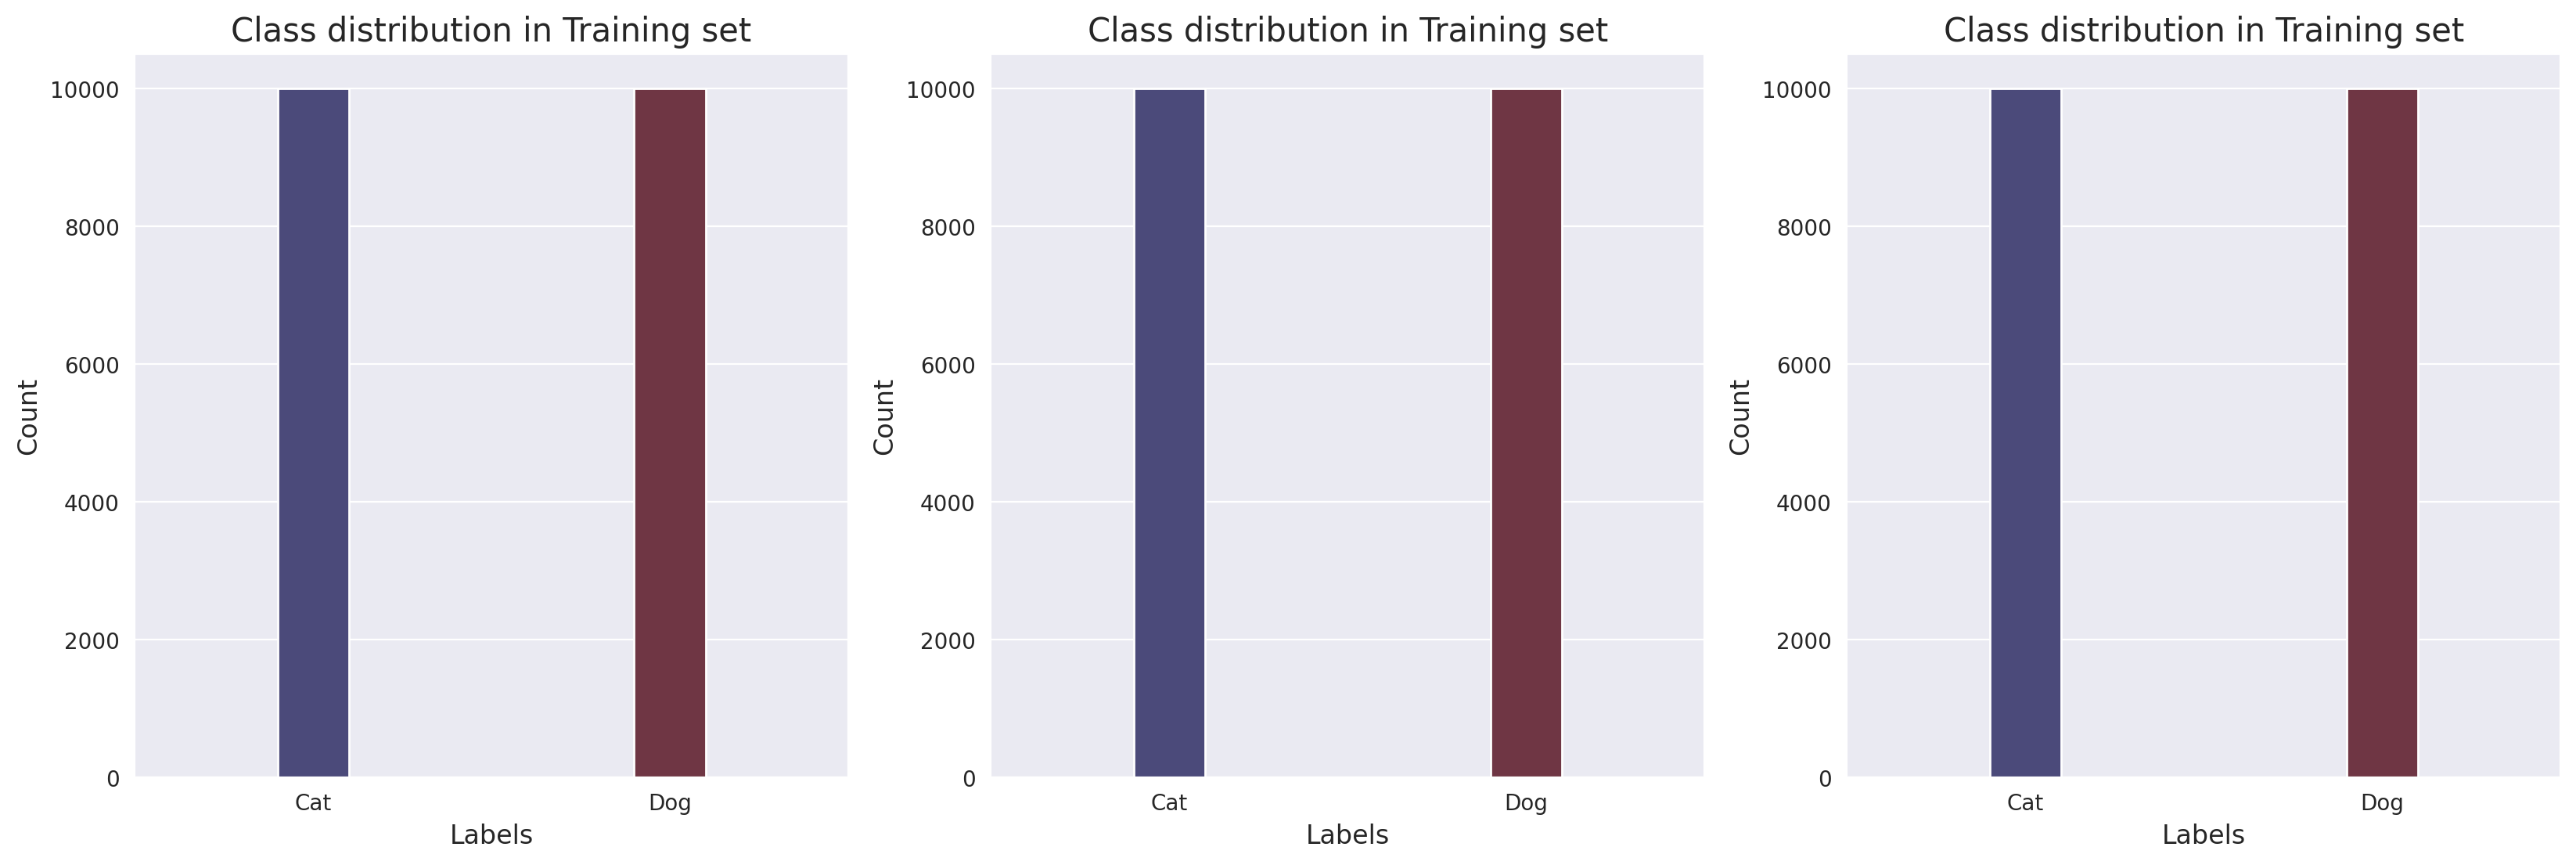

In [14]:
plt.figure(figsize=(20,6),dpi=200)
sns.set_style('darkgrid')

plt.subplot(131)
sns.barplot(data=uni1,x=uni1.index,y='Count1',palette='icefire',width=0.2).set_title('Class distribution in Training set', fontsize=15)
plt.xlabel('Labels', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.subplot(132)
sns.barplot(data=uni2,x=uni2.index,y='Count2',palette='icefire',width=0.2).set_title('Class distribution in Training set', fontsize=15)
plt.xlabel('Labels', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.subplot(133)
sns.barplot(data=uni3,x=uni3.index,y='Count3',palette='icefire',width=0.2).set_title('Class distribution in Training set', fontsize=15)
plt.xlabel('Labels', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.show()

# Image Median

In [15]:
image_dir = '/content/train/'
image_paths = [os.path.join(image_dir, filename) for filename in os.listdir(image_dir)]

image_width = []
image_height = []
for image_path in image_paths:
    image = cv.imread(image_path)
    height, width, _ = image.shape
    image_width.append(width)
    image_height.append(height)

median_width = np.median(image_width)
median_height = np.median(image_height)


print('median_size:', median_width,  'X', median_height)




median_size: 447.0 X 374.0


# Image Data Generator

* we will be using vgg16 preprocess_input for image data genrator.

* The data for will used by flow_from_dataframe.
* The batch size is 64 and the image size is (370,370).

In [16]:
batch_size = 64
size = (370, 370)

In [17]:
idg = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)

train_idg = idg.flow_from_dataframe(X_train, '/content/train/',
                                    X_col='filename',
                                    y_col='label',
                                    batch_size=batch_size,
                                   target_size=size )
val_idg = idg.flow_from_dataframe(X_val, "train/", x_col="filename", y_col="label",
                                  batch_size = batch_size,
                                  target_size = size, shuffle = False)

test_idg = idg.flow_from_dataframe(X_test, "train/", x_col= "filename", y_col= "label",
                                    batch_size = batch_size,
                                    target_size=size, shuffle = False)

Found 20000 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.


# Deep Learning model

### Pre-trained Base Model

Download vgg16 model and freeze the weights.

* By setting layer.trainable = False, freezing the weights of all the layers in the VGG16 model.The vgg16 derived weights will not be trained during the training of final model.

In [18]:
vgg16_model  = VGG16(include_top=False,input_shape=(370,370,3))

for layer in vgg16_model.layers:
  layer.trainable = False


58889256/58889256 [==============================] - 0s 0us/step


# Final Model

In [19]:
# Define Functional model

flat = Flatten() (vgg16_model.output)
dropout1 = Dropout(rate=0.2,name='Dropout1')(flat)
dense1 = Dense(128,activation='relu')(dropout1)
dropout2 = Dropout(rate=0.2,name='Dropout2')(dense1)
output = Dense(2,activation='softmax')(dropout2)

final_model = Model(inputs=[vgg16_model.input],outputs=[output])

# Compile the model

Finally we will compile the model .There are 3 things to mention here : Optimizer,Loss, Metrics.

* <b>Optimizer </b>:- To minimize cost function we use different methods For ex :- like gradient descent, stochastic gradient descent. So these are call optimizers. We are using a default one here which is adam.

* <b>Loss </b>:- To make our model better we either minimize loss or maximize accuracy. Neural Networks always minimize loss. To measure it we can use different formulas like 'categorical_crossentropy' or 'binary_crossentropy'. Here I have used binary_crossentropy.

* <b>Metrics </b>:- This is to denote the measure of your model. Can be accuracy or some other metric.

In [20]:
final_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

## callbacks

we will be using two callbacks -

* <b>ReduceLROnPlateau </b>: Reduce learning rate when a metric has stopped improving.
* <b>EarlyStopping </b> : Stop training when a monitored metric has stopped improving.

In [21]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=2,
                                            factor=0.5,
                                            min_lr=0.00001,
                                            verbose=1)
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               restore_best_weights=True,
                               verbose=0)

## fit the model

Fit the model
We are now going to train our compiled model using the train iterator (train_generator) and use the val iterator (val_generator) as a validation dataset during training.The model will be fit for 30 epochs

In [22]:
history = final_model.fit(train_idg,
                          batch_size=batch_size,
                          validation_data=val_idg,
                          epochs=20,
                          callbacks=[learning_rate_reduction,early_stopping])

Epoch 1/20
313/313 [==============================] - 337s 980ms/step - loss: 0.9857 - accuracy: 0.9559 - val_loss: 0.0573 - val_accuracy: 0.9796 - lr: 0.0010
Epoch 2/20
313/313 [==============================] - 286s 914ms/step - loss: 0.0363 - accuracy: 0.9853 - val_loss: 0.0673 - val_accuracy: 0.9868 - lr: 0.0010
Epoch 3/20
313/313 [==============================] - 286s 914ms/step - loss: 0.0252 - accuracy: 0.9901 - val_loss: 0.0804 - val_accuracy: 0.9824 - lr: 0.0010
Epoch 4/20
313/313 [==============================] - ETA: 0s - loss: 0.0192 - accuracy: 0.9919
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
313/313 [==============================] - 286s 914ms/step - loss: 0.0192 - accuracy: 0.9919 - val_loss: 0.0840 - val_accuracy: 0.9804 - lr: 0.0010
Epoch 5/20
313/313 [==============================] - 295s 943ms/step - loss: 0.0136 - accuracy: 0.9941 - val_loss: 0.0946 - val_accuracy: 0.9832 - lr: 5.0000e-04
Epoch 6/20
313/313 [====================

## Plot the result

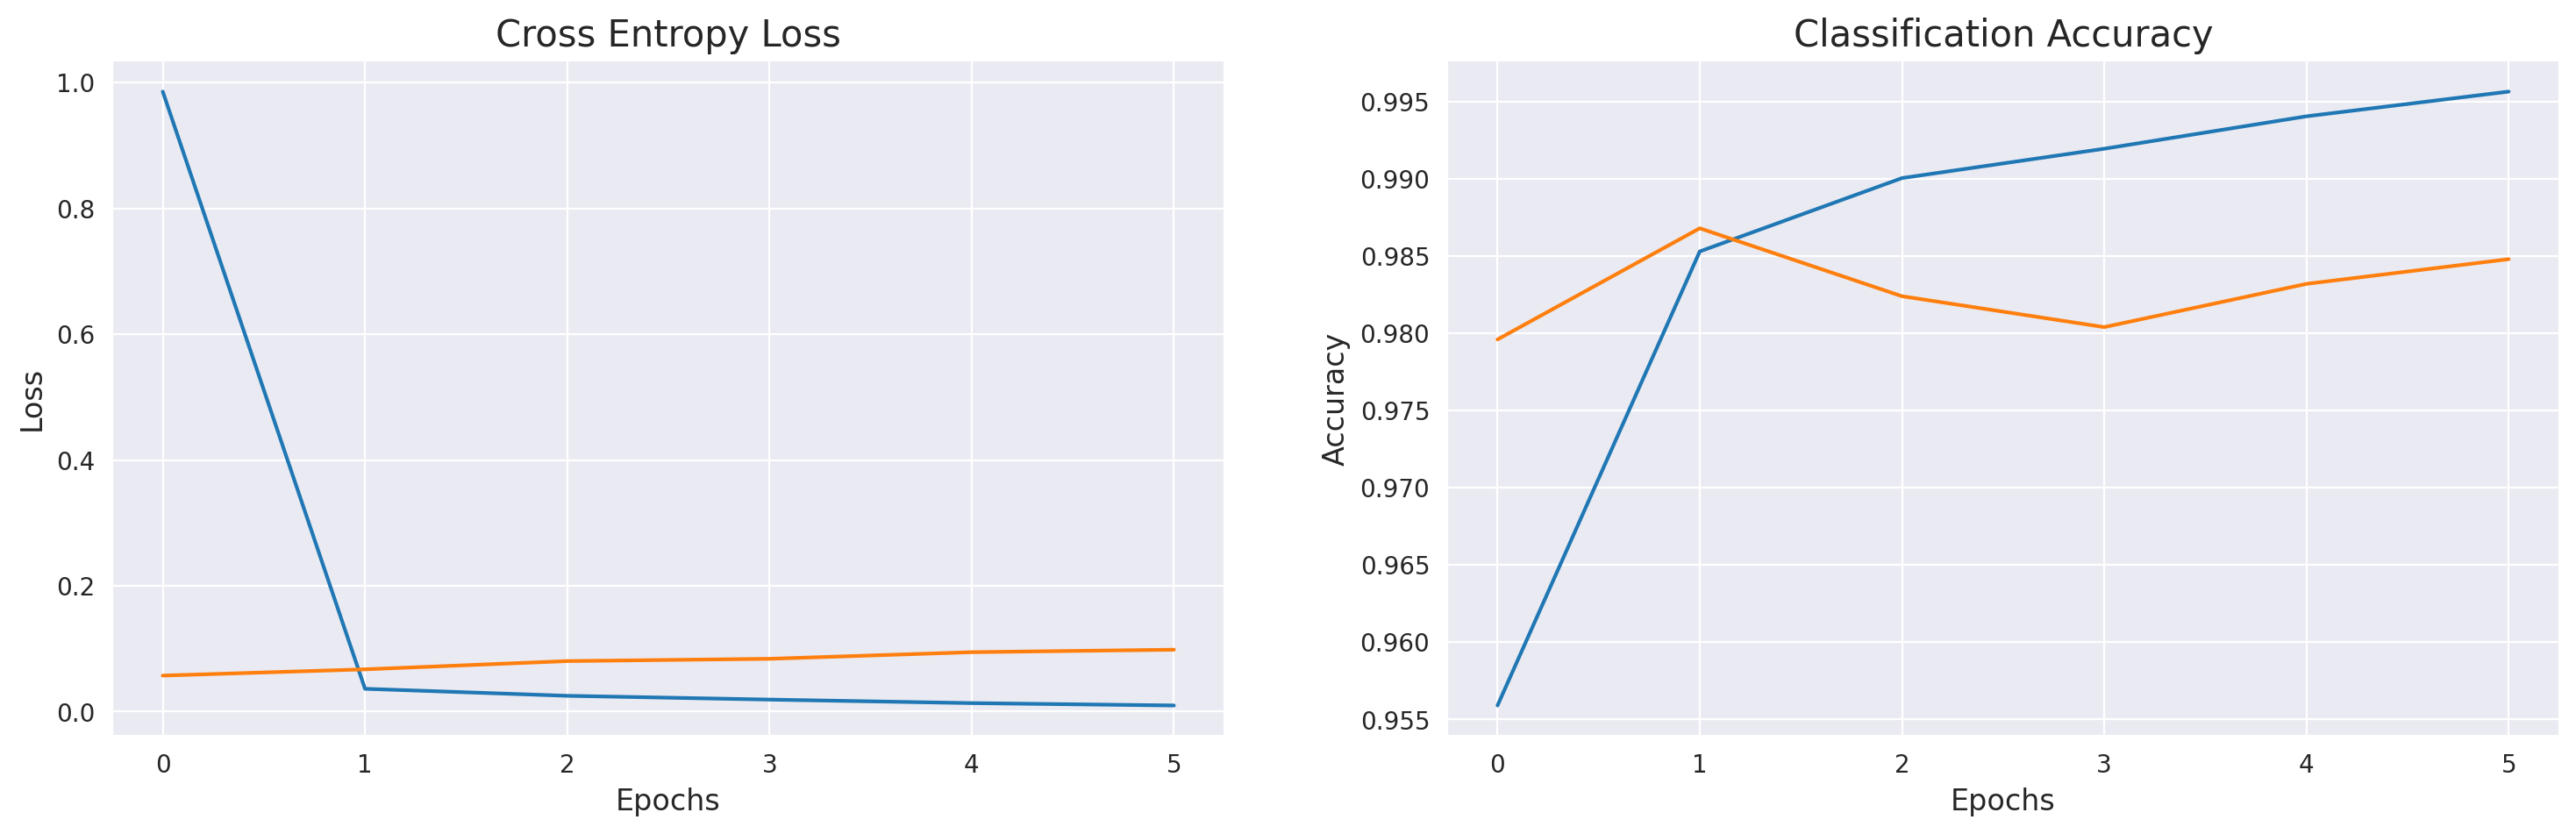

In [24]:

# plots for accuracy and Loss with epochs

error = pd.DataFrame(history.history)

plt.figure(figsize=(18,5),dpi=200)
sns.set_style('darkgrid')

plt.subplot(121)
plt.title('Cross Entropy Loss',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.plot(error['loss'])
plt.plot(error['val_loss'])

plt.subplot(122)
plt.title('Classification Accuracy',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.plot(error['accuracy'])
plt.plot(error['val_accuracy'])

plt.show()

 # Evaluation

In [25]:
loss3,acc3 = final_model.evaluate(train_idg,batch_size = batch_size, verbose = 0)

print('The accuracy of the model for training data is:',acc3*100)
print('The Loss of the model for training data is:',loss3)

The accuracy of the model for training data is: 99.16999936103821
The Loss of the model for training data is: 0.027780737727880478


In [26]:
# Evaluvate
loss3,acc3= final_model.evaluate(val_idg,batch_size = batch_size, verbose = 0)

print('The accuracy of the model for validation data is:',acc3*100)
print('The Loss of the model for validation data is:',loss3)

The accuracy of the model for validation data is: 97.96000123023987
The Loss of the model for validation data is: 0.05733519420027733


# Prediction

In [27]:
# Prediction
result = final_model.predict(test_idg)

result_argmax = np.argmax(result, axis=1)

y_true = test_idg.labels

y_pred = result_argmax

40/40 [==============================] - 33s 822ms/step


In [28]:
# Evaluvate
loss3,acc3 = final_model.evaluate(test_idg,batch_size = batch_size, verbose = 0)

print('The accuracy of the model for testing data is:',acc3*100)
print('The Loss of the model for testing data is:',loss3)

The accuracy of the model for testing data is: 98.0400025844574
The Loss of the model for testing data is: 0.05210179463028908


## Classification Report

In [29]:
labels =['Cat','Dog']
print(classification_report(y_true, y_pred,target_names=labels))

              precision    recall  f1-score   support

         Cat       0.98      0.98      0.98      1250
         Dog       0.98      0.98      0.98      1250

    accuracy                           0.98      2500
   macro avg       0.98      0.98      0.98      2500
weighted avg       0.98      0.98      0.98      2500



##Confusion matrix

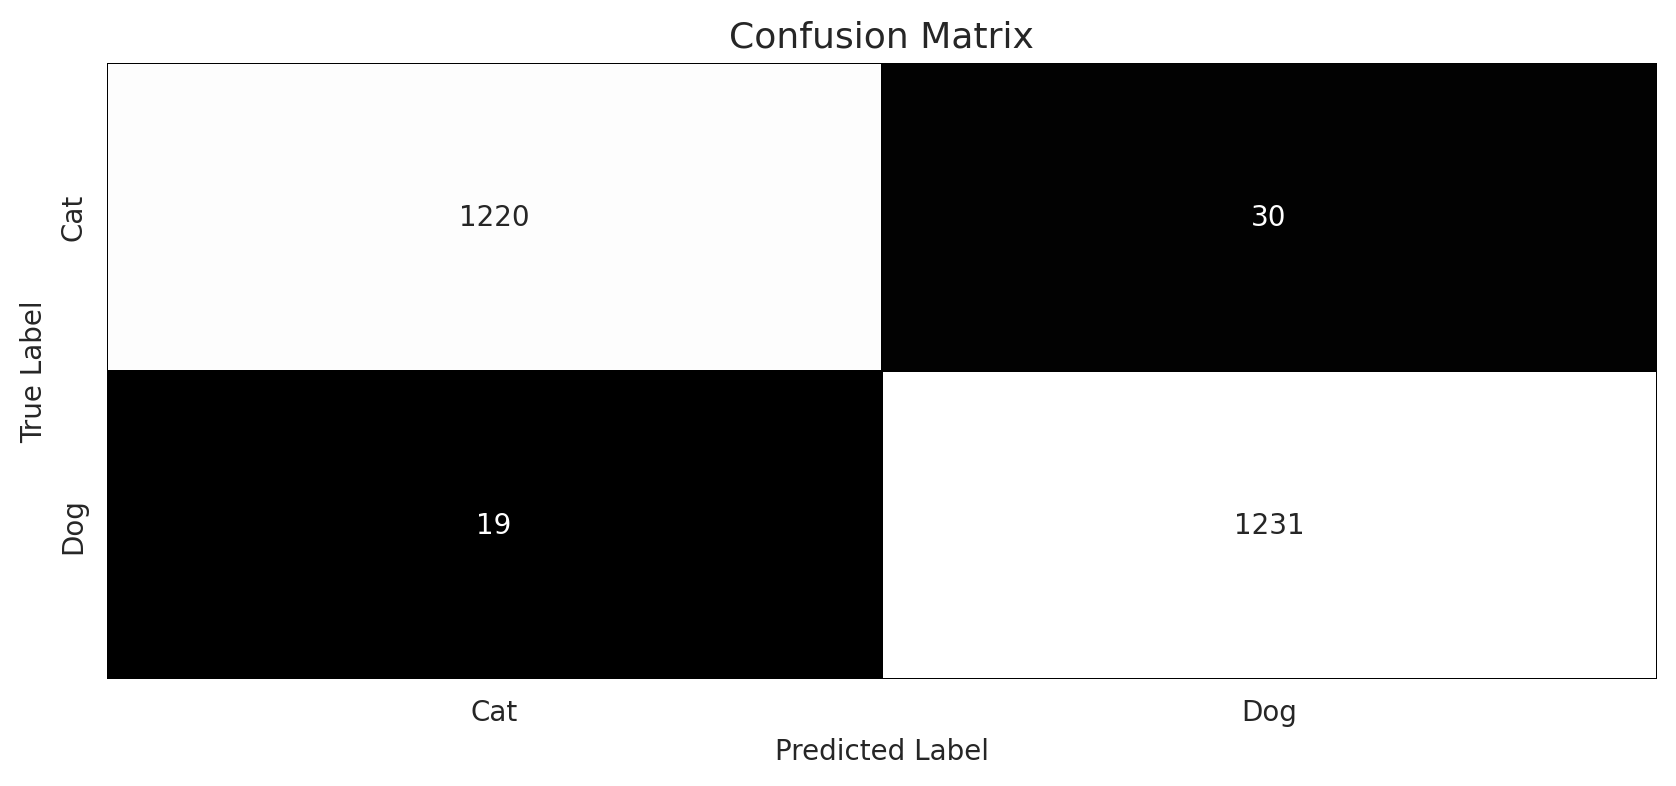

In [30]:
confusion_mtx = confusion_matrix(y_true,y_pred)

f,ax = plt.subplots(figsize = (10,4),dpi=200)
sns.heatmap(confusion_mtx, annot=True, linewidths=0.1, cmap = "gist_yarg_r", linecolor="black", fmt='.0f', ax=ax,cbar=False,xticklabels=labels,yticklabels=labels)
plt.xlabel("Predicted Label",fontsize=10)
plt.ylabel("True Label",fontsize=10)
plt.title("Confusion Matrix",fontsize=13)
plt.show()

In [31]:
# loading into dataframe
test_dir = "/content/test1/"
filenames = os.listdir(test_dir)
test_data = pd.DataFrame({"filename": filenames})
test_data['label'] = 'unknown'

In [32]:
# Create data genenerator for test data
test1_idg =  idg.flow_from_dataframe(test_data,
                                     "test1/",
                                     x_col= "filename",
                                     y_col = 'label',
                                     batch_size = batch_size,
                                     target_size=size,
                                     shuffle = False)

Found 12500 validated image filenames belonging to 1 classes.


In [33]:
# Test Prediction
test1_predict = final_model.predict(test1_idg)

test1_predict_argmax = np.argmax(test1_predict, axis=1)

y_test_pred = test1_predict_argmax

test_data['label'] = y_test_pred

# mapping
label_mapping = {0: 'cat', 1: 'dog'}
test_data['label'] = test_data['label'].map(label_mapping)
test_data.head()

196/196 [==============================] - 173s 882ms/step


,filename,label
0,4458.jpg,cat
1,6650.jpg,cat
2,5438.jpg,dog
3,11677.jpg,dog
4,7974.jpg,cat


## Visualize Classified Image

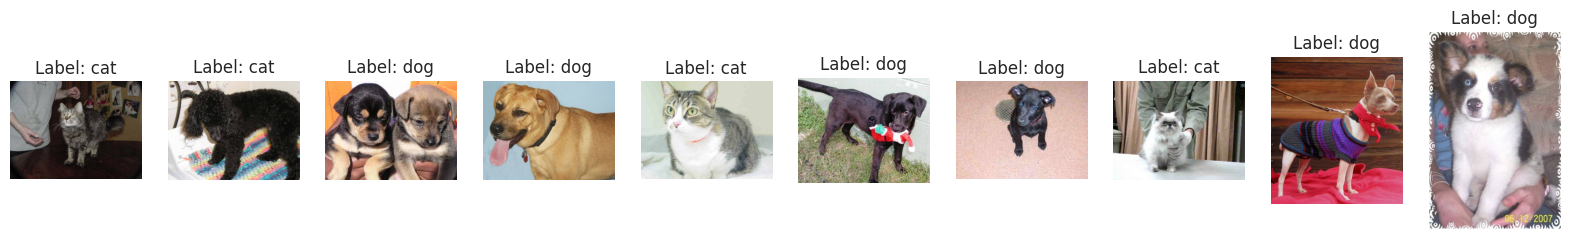

In [34]:
fig, axes = plt.subplots(1, 10, figsize=(20, 4))
for idx in range(10):
    image_path = os.path.join(test_dir, test_data.iloc[idx]['filename'])
    image = Image.open(image_path)
    axes[idx].imshow(image)
    axes[idx].set_title("Label: " + test_data.iloc[idx]['label'])
    axes[idx].axis('off')
plt.show()

# Conclusion

Using a pretrained model for Keras, VGG16, with a Dense model with softmax activation added on top and training with a reduced set of we were able to obtain quite good model in terms of validation accuracy.

The model was used to predict the classes of the images from the independent test set and results were submitted to test the accuracy of the prediction with fresh data.